# Reto 1

## Ingeniería de características

#### Miguel Ortiz y Andrea Castiella

In [2]:
import numpy  as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

In [3]:
FullSet_3 = pd.read_csv('../Reto1-Dataset/1000_tres.csv', header=None)
FullSet_7 = pd.read_csv('../Reto1-Dataset/1000_siete.csv', header=None)

# Reescalado a [0, 1]

FullSet_3 = FullSet_3 / 255.0
FullSet_7 = FullSet_7 / 255.0

## Función extracción de características

In [4]:
def feat_extraction(data, perc):
    num_feat = 6
    features = np.zeros([data.shape[0], num_feat])
    data = data.values.reshape([data.shape[0],28,28]) # Cada fila es una imagen, reshape a 28x28
    
    for i in range(data.shape[0]): # Por cada imagen 
        img = data[i,:,:]
        # Característica 1
        feat_1  = np.sum(img[:, :int(img.shape[1]*(perc))]) # Suma de los pixels del % izquierdo de la imagen
        features[i, 0] = feat_1
        # Característica 2
        feat_2 = np.sum(img[int(img.shape[0]*(1-perc)):, :]) # Suma de los pixels del % mitad inferior de la imagen
        features[i, 1] = feat_2
        # Característica 3
        feat_3 = np.sum(img[:, int(img.shape[1]*(1-perc)):]) # Suma de los pixels del % mitad derecho de la imagen
        features[i, 2] = feat_3
        # Característica 4
        feat_4 = np.sum(img[:int(img.shape[0]*(perc)), :]) # Suma de los pixels del % mitad superior de la imagen
        features[i, 3] = feat_4
        # Característica 5
        feat_5 = np.sum(img[int(img.shape[0]*(0.5)):,:int(img.shape[1]*(0.5))]) # Suma del cuadrante inferior izquierdo
        features[i, 4] = feat_5
        # Característica 6
        feat_6 = np.amax(np.sum(img, axis=0)) # Máximo valor de la suma de las columnas
        features[i, 5] = feat_6
    col_names = ['feat_1','feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']
    return pd.DataFrame(features,columns = col_names)

## Utils functions

In [5]:
def jitter(data, sigma=0.3):
    #random_sign = (-1)**np.random.randint(1,3,*data.shape)
    random_sign = (-1.)**np.random.randint(1,high=3,size=data.shape)
    return data + np.random.normal(0,sigma,size=data.shape)*random_sign

def single_stratified_split(X, Y, test_size=.2, random_state=1234):
    # X is the dataframe with examples (rows) and attributes (columns)
    # Y is the dataframe with labels
    # test_size is the percentage of X separated; default is 0.2
    # random_state is a seed for pseudorandom generation
    # returns
    #   X_train, Y_train = dataframes of (1-test_size)% of the X and Y
    #   X_test, Y_test = dataframes of test_size% of the X and Y
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    split_ix = splitter.split(X,Y)
    for train_ix, test_ix in split_ix:
        X_train = X.loc[train_ix].reset_index(drop=True)
        Y_train = Y.loc[train_ix].reset_index(drop=True)
        X_test  = X.loc[test_ix].reset_index(drop=True)
        Y_test  = Y.loc[test_ix].reset_index(drop=True)
    return X_train, Y_train, X_test, Y_test

def join_features_labels(X0, X1):
    # X0, X1: dataframes
    # returns a dataframe with X0 and X1 together and
    #   a new column 'label'
    #   = 0 for rows from X0
    #   = 1 for rows from X1
    #
    Y0 = pd.DataFrame(np.zeros(X0.shape[0]),columns=['label'])
    XY0 = pd.concat([X0,Y0],axis=1)
    Y1 = pd.DataFrame(np.ones(X1.shape[0]),columns=['label'])
    XY1 = pd.concat([X1,Y1],axis=1)
    return pd.concat([XY0,XY1],axis=0,ignore_index=True)

## Features

In [6]:
FullSet = join_features_labels(FullSet_3, FullSet_7)
seed = 1234
theta = 0.5
X_full = feat_extraction(FullSet.drop('label', axis=1), perc=0.3)
Y_full = FullSet[['label']]
test_size = 0.2
splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
split_ix = splitter.split(X_full,Y_full)

for train_ix, test_ix in split_ix:
    X_train = X_full.loc[train_ix].reset_index(drop=True)
    #Reordena los índices
        #print(X_full.loc[train_ix])
        #print(X_train)
    Y_train = Y_full.loc[train_ix].reset_index(drop=True)
    X_test  = X_full.loc[test_ix].reset_index(drop=True)
    Y_test  = Y_full.loc[test_ix].reset_index(drop=True)

In [15]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X_train[['feat_4']])
Y = Y_train.values.ravel() #Devuelve data como numpy

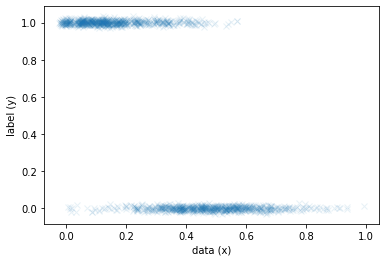

In [16]:
plt.plot(jitter(X,sigma=0.01), jitter(Y,sigma=0.01),'x',alpha=0.1)
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

## Logistic Regression

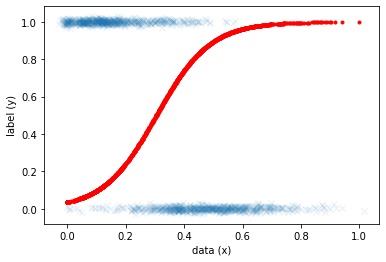

In [17]:
from sklearn.linear_model import LogisticRegression

recta_regresion = LogisticRegression()
recta_regresion.fit(X,Y)
y_CDF = recta_regresion.predict_proba(X)
y_pred = y_CDF[:,1]  #<-- use 0 instead of 1 to see the logistic curve of the other class


plt.plot(jitter(X,sigma=0.01), jitter(Y,sigma=0.01),'x',alpha=0.1)
plt.plot(X, y_pred, '.r')
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

## Discriminant Function

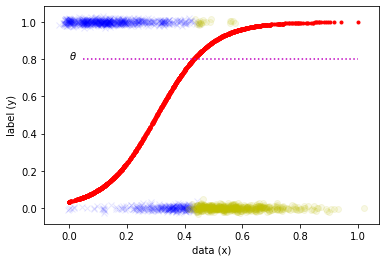

In [18]:
theta = 0.8 #<-- paramter of the discriminant function

ix_1 = y_pred < theta
ix_0 = ~ix_1
plt.plot( jitter(X[ix_1],sigma=0.01), \
          jitter(Y[ix_1],sigma=0.01), \
          'bx',alpha=0.1)
plt.plot( jitter(X[ix_0],sigma=0.01), \
          jitter(Y[ix_0],sigma=0.01), \
          'yo',alpha=0.1)
plt.text(0,theta, r'$ \theta $')
plt.plot(X,y_pred,'.r')
plt.plot([0.05,1],[theta,theta],'m:')
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()